In [1]:
import torch

In [2]:
# train mobile and simple cnn 

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        net = models.mobilenet_v3_small(pretrained=False)
        
        self.trunk = nn.Sequential(*(list(net.children())[:-2]))
        
        
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Linear(576, 10, bias=True),
            nn.LogSoftmax(dim=1)
        )
        

    def forward(self, x):
        
        x = self.trunk(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings

    no_cuda = False
    seed = 1111
    batch_size = 128
    test_batch_size = 1000
    lr = 0.01
    save_model = True
    epochs = 2
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'batch_size': test_batch_size,'shuffle':True}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': False}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    dataset2 = datasets.ImageFolder('mnist/testing',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, num_workers=8)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    #model = MobileNet().to(device)
        
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr)

    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    for epoch in range(1, epochs + 1):
        train( model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
        #torch.save(model.state_dict(), "mnist_mobile.pt")
    
    
    return model



In [4]:
model = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306674
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.408554
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.187409
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.207236
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.153625

Test set: Average loss: 0.0767, Accuracy: 9753/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.065316
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.073221
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.113927
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.138934
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.134654

Test set: Average loss: 0.0450, Accuracy: 9847/10000 (98%)



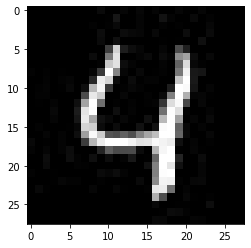

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

four_img = Image.open("mnist/pic/4.jpg")
four_img = four_img.convert('RGB')
transform=transforms.Compose([
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


four_tensor = transform(four_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(four_tensor[0].numpy().transpose(1,2,0))


In [6]:

def cnn_eval(tensor):
    model=Net()
    model.load_state_dict(torch.load("mnist_cnn.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

def mobile_eval(tensor):
    model=MobileNet()
    model.load_state_dict(torch.load("mnist_mobile.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

mobile_eval(norm(four_tensor))
cnn_eval(norm(four_tensor))

tensor(4)
tensor(4)


In [7]:
## fgsm to get a wrong prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-22.9877, grad_fn=<NegBackward0>)
tensor(4)
None


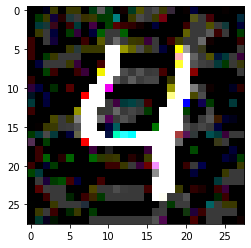

In [8]:
gt = 5
delta = torch.zeros_like(four_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=10)
epsilon = 0.2
for t in range(20):
    pred = model(norm(four_tensor + delta))

    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
    

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
print(loss)
print(cnn_eval(norm(four_tensor + delta)))
plt.imshow(norm(four_tensor + delta)[0].detach().numpy().transpose(1,2,0))


In [9]:
# pgd more powerful 
# targeted attack: control model to give a target value

8
0 14.67684555053711
50 0.37476295232772827
100 -0.4254000782966614
150 -0.7032363414764404
200 -0.937480092048645
250 -1.0612775087356567
300 -1.1266465187072754
350 -1.1796194314956665
400 -1.2356950044631958
450 -1.301567792892456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class probability: tensor([[0.0037, 0.0102, 0.1287, 0.0081, 0.0376, 0.0009, 0.0021, 0.0019, 0.7480,
         0.0587]], grad_fn=<SoftmaxBackward0>)
tensor(8)


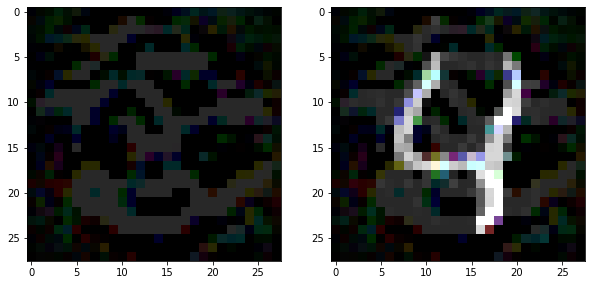

In [10]:
import torch.optim as optim

model.eval()
def l_infinity_pgd(model, tensor, gt,epsilon=40./255, target=None,iteration=500, show=True):
    delta = torch.zeros_like(tensor, requires_grad=True)
    opt = optim.SGD([delta], lr=0.1)
    print(target)
    for t in range(iteration):
        pred = model(norm(tensor + delta))
        if target is None:
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
        else:

            loss = - 0.5 * nn.CrossEntropyLoss()(pred, torch.LongTensor([4])) + nn.CrossEntropyLoss()(pred, torch.LongTensor([target]))
        if t % 50 == 0:
            print(t, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    print("True class probability:", nn.Softmax(dim=1)(pred))
    cnn_eval(norm(tensor+delta))

    if show:
        f,ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow((delta)[0].detach().numpy().transpose(1,2,0))
        ax[1].imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))
    
    return tensor + delta

x= l_infinity_pgd(model,four_tensor,4,target=8)

In [11]:
## 是不是像才可以？铁男都可以是数字？？？ 其实图片越复杂，对抗扰动就越难以察觉

tensor(7)


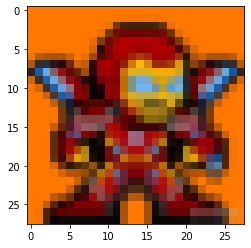

In [12]:
import torch.optim as optim

rem_img = Image.open("mnist/pic/tienan.jpeg")
rem_img = rem_img.convert('RGB')
transform=transforms.Compose([
    transforms.Resize((28,28))  ,
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


rem_tensor = transform(rem_img)[None,:,:,:]
cnn_eval(norm(rem_tensor))
plt.imshow(rem_tensor[0].numpy().transpose(1,2,0))


8
0 1.2870841026306152
50 -6.226268291473389
100 -6.863039970397949
150 -7.106522560119629
200 -7.233801364898682
250 -7.310367107391357
300 -7.367360591888428
350 -7.410129547119141
400 -7.4365363121032715
450 -7.456101894378662


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class probability: tensor([[5.2133e-04, 2.5100e-04, 3.9893e-02, 4.6339e-03, 2.9165e-07, 1.8009e-04,
         8.9095e-06, 1.3336e-03, 9.5316e-01, 1.7141e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)


tensor([[[[ 0.9856,  0.9773,  0.9060,  ...,  1.0878,  0.9452,  0.9938],
          [ 1.0361,  1.0358,  0.8808,  ...,  0.8804,  0.8742,  0.9953],
          [ 1.0396,  1.1240,  0.9011,  ...,  0.9531,  0.9934,  1.0384],
          ...,
          [ 0.8431,  0.8314,  0.6159,  ...,  0.7332,  1.0585,  1.0900],
          [ 0.8750,  0.8442,  0.4510,  ...,  0.4563,  1.0158,  0.9857],
          [ 0.9594,  0.9089,  0.3198,  ...,  0.3493,  0.9958,  0.9924]],

         [[ 0.4960,  0.5319,  0.4248,  ...,  0.4863,  0.4974,  0.4759],
          [ 0.4675,  0.4483,  0.4552,  ...,  0.4132,  0.4017,  0.4934],
          [ 0.5398,  0.5678,  0.4977,  ...,  0.4440,  0.3831,  0.4889],
          ...,
          [ 0.3914,  0.3607,  0.4093,  ...,  0.2521,  0.6196,  0.5494],
          [ 0.4357,  0.3039,  0.0272,  ...,  0.3274,  0.6397,  0.5541],
          [ 0.4457,  0.4429,  0.1205,  ...,  0.3149,  0.5572,  0.5009]],

         [[ 0.0250,  0.0326, -0.0439,  ...,  0.0131,  0.0193,  0.0129],
          [ 0.0300, -0.1006,  

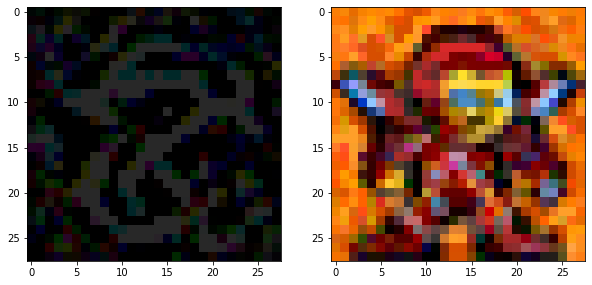

In [13]:

import torch.optim as optim
# 注意修改gt为输出值
pred = 7
l_infinity_pgd(model,rem_tensor,pred,40./255,8,500)

In [14]:
# 统一视角 各种算法 
# 1) the norm ball perturbation they consider, 
# 2) the method they use for optimizing over that norm ball

In [15]:
# transfer attack 使用simple cnn产生的攻击样本，对mobile会有影响吗？


In [16]:
# create dataset
import os
from torchvision.utils import save_image
def create_adv_dataset():
    transform=transforms.Compose([
        transforms.ToTensor()
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=8)
    
    attack_target = 0 
    # 每个数字生成100个对抗样本
    for batch_idx, (data, target) in enumerate(train_loader):
        attack_target = batch_idx//100
        if target== attack_target:
            continue
        if attack_target>9:
            break
        model=Net()
        model.load_state_dict(torch.load("mnist_cnn.pt"))
        model.eval()
        adv_img = l_infinity_pgd(model,data,target,35./255,attack_target,50,False)
        image_dir_1 = os.path.join('mnist/adv_ori_label',str(target.item()))
        image_dir_2 = os.path.join('mnist/adv_adv_label',str(attack_target))
        if not os.path.exists(image_dir_1):
            os.makedirs(image_dir_1)
        if not os.path.exists(image_dir_2):
            os.makedirs(image_dir_2)
        
        save_image(adv_img, os.path.join(image_dir_1,str(batch_idx)+'.jpg'))
        save_image(adv_img, os.path.join(image_dir_2,str(batch_idx)+'.jpg'))

create_adv_dataset()    

0
0 10.4041109085083
True class probability: tensor([[0.0012, 0.9146, 0.0038, 0.0061, 0.0028, 0.0095, 0.0159, 0.0051, 0.0324,
         0.0086]], grad_fn=<SoftmaxBackward0>)
tensor(1)
0
0 8.882957458496094
True class probability: tensor([[8.1212e-05, 3.1669e-05, 6.6332e-04, 4.1284e-04, 1.2068e-06, 4.9489e-05,
         2.8162e-07, 9.9656e-01, 1.2614e-04, 2.0705e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)
0
0 1.0495047569274902
True class probability: tensor([[2.8632e-01, 3.4473e-05, 9.7009e-05, 2.0255e-05, 2.0457e-06, 8.4998e-02,
         2.2219e-01, 1.0960e-05, 4.0616e-01, 1.6195e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
0
0 8.739896774291992
True class probability: tensor([[1.2161e-03, 1.9465e-06, 4.6991e-06, 4.7653e-06, 6.2399e-07, 9.3696e-01,
         1.9127e-05, 6.6907e-05, 6.1387e-02, 3.3632e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
0
0 6.399796962738037
True class probability: tensor([[1.9830e-03, 2.5568e-05, 1.1104e-02, 1.2399e-04, 1.2623e-07, 1.2713e-

tensor(1)
0
0 9.171770095825195
True class probability: tensor([[1.2087e-04, 1.3986e-05, 4.2158e-03, 6.5900e-05, 2.8106e-08, 2.8562e-06,
         5.6231e-08, 4.5992e-05, 9.9548e-01, 5.1735e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
0
0 7.93211555480957
True class probability: tensor([[8.0749e-07, 9.4302e-05, 9.9963e-01, 1.6023e-04, 3.0165e-10, 9.6292e-09,
         2.7964e-09, 6.0214e-05, 5.9086e-05, 3.2761e-08]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
0
0 11.158670425415039
True class probability: tensor([[8.3564e-06, 3.1920e-08, 3.4967e-07, 5.5694e-05, 1.4695e-08, 9.9962e-01,
         1.0452e-05, 4.7549e-07, 5.1857e-05, 2.5307e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
0
0 5.221525192260742
True class probability: tensor([[7.0864e-04, 9.5279e-07, 1.3675e-02, 1.7962e-05, 3.2236e-10, 2.9007e-07,
         4.3548e-08, 2.2569e-06, 9.8559e-01, 5.2136e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
0
0 6.050220489501953
True class probability: tensor([[8.6469e-02,

True class probability: tensor([[7.9781e-03, 8.2646e-06, 1.3291e-02, 6.0710e-07, 4.0311e-07, 2.5894e-04,
         1.5958e-02, 1.2615e-07, 9.6250e-01, 1.3989e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
0
0 7.5682597160339355
True class probability: tensor([[1.7451e-03, 2.2724e-06, 2.5818e-04, 5.1498e-03, 2.8331e-07, 1.1089e-04,
         9.6534e-08, 3.4829e-02, 3.8358e-04, 9.5752e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
0
0 17.15737533569336
True class probability: tensor([[1.6920e-07, 4.8043e-06, 8.8037e-05, 9.9672e-01, 3.5988e-09, 1.0299e-05,
         2.0326e-10, 4.2271e-05, 2.6753e-03, 4.6334e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
0
0 8.074942588806152
True class probability: tensor([[8.2293e-01, 6.1929e-05, 1.2634e-02, 4.5638e-07, 1.0138e-02, 1.8833e-05,
         1.5173e-01, 3.6052e-05, 2.4071e-03, 3.8631e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(0)
0
0 18.764244079589844
True class probability: tensor([[1.4684e-03, 3.0031e-03, 6.3752e-03, 9.377

True class probability: tensor([[1.0047e-05, 4.5493e-03, 5.9202e-04, 3.5722e-05, 1.1953e-05, 9.6931e-03,
         8.5203e-01, 6.6143e-07, 1.3307e-01, 3.3136e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(6)
1
0 8.854207992553711
True class probability: tensor([[3.9077e-03, 2.9944e-03, 3.7652e-03, 1.0534e-01, 1.7306e-03, 1.0135e-02,
         1.0747e-04, 5.3488e-01, 3.4711e-03, 3.3367e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)
1
0 10.81298828125
True class probability: tensor([[9.9967e-01, 5.1458e-06, 2.5613e-04, 4.5219e-07, 1.3921e-06, 8.5903e-08,
         5.1407e-05, 6.9242e-07, 1.6616e-05, 1.8884e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(0)
1
0 -1.6944184303283691
True class probability: tensor([[4.8088e-07, 1.2257e-03, 9.4572e-01, 2.6000e-03, 1.2901e-09, 5.7387e-10,
         4.3682e-10, 5.0135e-02, 3.1597e-04, 1.7298e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
1
0 5.863548278808594
True class probability: tensor([[3.6635e-07, 4.3263e-04, 9.9936e-05, 9.9926e-

True class probability: tensor([[9.7129e-01, 8.7781e-05, 5.4905e-03, 5.0484e-04, 2.3674e-04, 2.8766e-03,
         5.3781e-03, 1.8565e-03, 1.7170e-03, 1.0560e-02]],
       grad_fn=<SoftmaxBackward0>)
tensor(0)
1
0 4.570789337158203
True class probability: tensor([[4.3803e-08, 2.3466e-07, 9.9992e-01, 4.2568e-05, 5.2165e-13, 1.3290e-11,
         9.2283e-13, 3.6924e-05, 1.9800e-07, 3.1607e-10]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
1
0 13.99551773071289
True class probability: tensor([[8.1770e-05, 2.0752e-05, 5.5747e-04, 2.0604e-06, 4.1947e-04, 9.2672e-05,
         9.9879e-01, 4.7178e-08, 3.2283e-05, 5.2752e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(6)
1
0 12.489665985107422
True class probability: tensor([[1.6544e-05, 2.8864e-05, 7.6100e-06, 1.0448e-07, 1.3318e-05, 6.9529e-05,
         9.9982e-01, 6.9989e-08, 4.0276e-05, 2.8092e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(6)
1
0 14.28930950164795
True class probability: tensor([[1.1790e-07, 8.7968e-06, 2.6691e-06, 1.5443

tensor(2)
2
0 -0.7375564575195312
True class probability: tensor([[1.6248e-09, 4.8106e-05, 2.9084e-01, 6.8108e-01, 8.7316e-12, 1.4204e-10,
         4.4299e-11, 2.8027e-02, 7.4942e-06, 1.0791e-08]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
2
0 15.597030639648438
True class probability: tensor([[1.5211e-03, 1.5323e-03, 6.2552e-03, 2.3869e-04, 7.5690e-01, 7.7071e-04,
         1.0748e-02, 5.1279e-04, 2.6629e-02, 1.9489e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(4)
2
0 5.243678569793701
True class probability: tensor([[4.4394e-04, 1.6342e-01, 5.3339e-01, 4.3335e-02, 8.9885e-05, 4.1573e-05,
         3.5860e-05, 2.5192e-01, 6.7581e-03, 5.7143e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
2
0 11.176961898803711
True class probability: tensor([[1.0490e-03, 3.0528e-03, 7.1667e-02, 2.5621e-02, 7.3621e-04, 4.5773e-03,
         2.6449e-05, 3.5335e-01, 8.2649e-02, 4.5728e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
2
0 -2.0991787910461426
True class probability: tensor([[2.503

2
0 8.315964698791504
True class probability: tensor([[9.4923e-06, 5.9639e-01, 4.0134e-01, 6.0769e-05, 4.1178e-06, 1.1903e-06,
         2.9004e-05, 6.5474e-04, 1.5138e-03, 1.8522e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
2
0 3.373258590698242
True class probability: tensor([[9.3685e-01, 9.9769e-07, 6.1379e-02, 1.8587e-06, 6.0075e-10, 9.1909e-08,
         5.6699e-07, 4.4997e-07, 1.7606e-03, 3.0399e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(0)
2
0 4.7223615646362305
True class probability: tensor([[2.3084e-09, 9.5761e-07, 8.3656e-05, 1.9624e-05, 1.1990e-10, 7.3195e-10,
         2.3236e-11, 9.9989e-01, 7.3037e-07, 2.2780e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)
2
0 9.19395637512207
True class probability: tensor([[2.7690e-06, 2.7049e-06, 1.1850e-02, 1.6502e-06, 6.9710e-05, 1.8745e-04,
         9.8784e-01, 7.7023e-09, 4.7967e-05, 6.3569e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(6)
2
0 5.935318470001221
True class probability: tensor([[6.1164e-04, 1.7998e-0

2
0 4.078336715698242
True class probability: tensor([[9.9997e-01, 1.8884e-09, 1.2731e-05, 2.0360e-09, 4.3029e-12, 2.8784e-07,
         1.0005e-07, 1.1184e-08, 1.1776e-05, 1.5585e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(0)
2
0 2.1421213150024414
True class probability: tensor([[8.5917e-08, 1.3738e-05, 6.1846e-01, 6.8247e-04, 2.4250e-11, 2.2766e-09,
         1.0495e-09, 1.5043e-05, 3.8083e-01, 1.2054e-08]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
2
0 0.5549945831298828
True class probability: tensor([[6.0373e-08, 1.8765e-04, 5.2573e-02, 1.8409e-03, 1.8602e-09, 5.5455e-08,
         2.9404e-09, 9.4524e-01, 1.5845e-04, 1.6701e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)
2
0 7.987834930419922
True class probability: tensor([[4.2460e-04, 6.5579e-01, 3.0134e-01, 2.2824e-03, 1.3330e-04, 8.0084e-04,
         2.4183e-03, 9.9305e-03, 2.6813e-02, 6.7623e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
2
0 0.06894779205322266
True class probability: tensor([[6.8433e-07, 7.183

tensor(9)
3
0 0.6108627319335938
True class probability: tensor([[1.7450e-11, 2.2773e-08, 3.1551e-09, 6.8642e-01, 3.9008e-09, 3.1280e-01,
         1.1090e-09, 8.6700e-10, 5.9992e-05, 7.2358e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
3
0 -3.6635866165161133
True class probability: tensor([[7.5530e-12, 3.3403e-07, 9.9240e-01, 7.5903e-03, 3.2129e-15, 1.7945e-14,
         1.7795e-15, 5.1070e-06, 1.7899e-07, 3.8317e-12]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
3
0 11.472413063049316
True class probability: tensor([[1.0893e-05, 7.4541e-03, 1.1741e-03, 6.6506e-02, 2.6410e-03, 5.3658e-03,
         9.4972e-06, 4.3406e-04, 7.8989e-01, 1.2651e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
3
0 9.557350158691406
True class probability: tensor([[1.6353e-03, 7.9886e-01, 1.4117e-01, 1.3826e-02, 2.5869e-04, 3.0300e-04,
         2.2811e-03, 9.2105e-03, 3.2354e-02, 1.0323e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
3
0 8.434793472290039
True class probability: tensor([[2.9919e

tensor(2)
3
0 -2.7703065872192383
True class probability: tensor([[1.6858e-08, 2.8786e-07, 9.9879e-01, 1.1771e-03, 4.0889e-14, 4.2738e-13,
         1.2823e-14, 2.6742e-05, 8.0087e-07, 8.1797e-10]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
3
0 2.0129318237304688
True class probability: tensor([[1.3455e-10, 9.3713e-09, 3.9104e-10, 6.7852e-02, 1.8287e-11, 9.3214e-01,
         1.9210e-10, 5.0120e-08, 2.4540e-06, 8.0599e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
3
0 7.501735210418701
True class probability: tensor([[1.3024e-06, 8.1975e-01, 5.4207e-04, 1.7676e-01, 2.9795e-04, 5.9289e-05,
         8.0167e-06, 5.8292e-04, 1.6913e-03, 3.0444e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
3
0 20.61496925354004
True class probability: tensor([[1.2711e-06, 3.6275e-03, 4.2829e-04, 2.0231e-01, 3.4305e-01, 2.5462e-03,
         3.2084e-05, 4.2942e-03, 2.3123e-01, 2.1248e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(4)
3
0 2.881063461303711
True class probability: tensor([[4.6403e-

True class probability: tensor([[3.6215e-04, 2.2703e-03, 9.3609e-01, 1.7265e-02, 2.0707e-02, 1.7545e-03,
         1.7729e-03, 1.6346e-03, 1.1192e-02, 6.9561e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
4
0 13.000410079956055
True class probability: tensor([[8.0117e-07, 3.5740e-04, 5.8079e-03, 6.7458e-01, 1.6437e-05, 2.4621e-04,
         2.7233e-06, 2.2230e-05, 3.1885e-01, 1.1328e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
4
0 8.445558547973633
True class probability: tensor([[3.7240e-04, 3.9255e-06, 2.1440e-04, 1.5747e-04, 3.2310e-03, 9.1528e-01,
         2.6907e-03, 5.8961e-05, 3.0525e-02, 4.7468e-02]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
4
0 13.628541946411133
True class probability: tensor([[9.9977e-01, 6.7518e-07, 3.8468e-06, 6.4306e-08, 1.4408e-07, 3.8512e-06,
         1.8771e-04, 3.5522e-06, 2.5783e-05, 8.3259e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(0)
4
0 10.399972915649414
True class probability: tensor([[1.8346e-02, 1.3499e-03, 9.0026e-03, 2.12

tensor(0)
4
0 3.235389471054077
True class probability: tensor([[0.0550, 0.0043, 0.3652, 0.0379, 0.4256, 0.0009, 0.0272, 0.0054, 0.0068,
         0.0717]], grad_fn=<SoftmaxBackward0>)
tensor(4)
4
0 8.39241886138916
True class probability: tensor([[1.5223e-07, 5.3276e-08, 5.1354e-07, 3.4247e-05, 2.6644e-03, 6.3408e-01,
         4.0815e-06, 1.1084e-06, 2.5287e-03, 3.6069e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
4
0 8.860983848571777
True class probability: tensor([[1.3892e-06, 4.3217e-04, 2.7128e-06, 4.9516e-04, 2.3730e-03, 1.6263e-02,
         2.6555e-05, 3.2021e-05, 9.1122e-01, 6.9154e-02]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
4
0 5.737703800201416
True class probability: tensor([[7.2254e-06, 6.6905e-06, 1.8745e-05, 3.0775e-07, 5.0058e-03, 2.5679e-05,
         9.9490e-01, 5.8348e-07, 3.0325e-05, 5.9009e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(6)
4
0 4.808223724365234
True class probability: tensor([[5.6503e-05, 2.1582e-05, 2.0523e-04, 2.4709e-05, 8.0550e-01,

tensor(6)
4
0 6.122858047485352
True class probability: tensor([[0.0014, 0.0115, 0.0652, 0.0658, 0.0041, 0.0058, 0.0012, 0.8317, 0.0059,
         0.0074]], grad_fn=<SoftmaxBackward0>)
tensor(7)
4
0 10.726378440856934
True class probability: tensor([[1.1440e-03, 1.0188e-01, 8.7021e-01, 4.3422e-03, 1.5124e-04, 4.5475e-05,
         1.3579e-04, 1.7686e-02, 4.1033e-03, 3.0470e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
4
0 6.8725433349609375
True class probability: tensor([[3.2257e-02, 9.1742e-04, 7.6847e-01, 3.9238e-04, 1.1191e-01, 8.4002e-04,
         4.0832e-02, 3.5579e-04, 4.1952e-02, 2.0772e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
4
0 12.122851371765137
True class probability: tensor([[2.9659e-06, 1.1449e-04, 4.5353e-04, 8.1150e-04, 2.2452e-06, 1.3124e-06,
         5.3735e-08, 9.9824e-01, 3.4901e-05, 3.3634e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)
4
0 10.525228500366211
True class probability: tensor([[1.7528e-06, 2.4465e-05, 2.9957e-05, 8.4132e-05, 1.1142

5
0 8.485946655273438
True class probability: tensor([[1.0589e-04, 2.8517e-02, 9.5089e-01, 9.8488e-03, 6.6973e-06, 2.4666e-04,
         5.6668e-05, 4.1561e-03, 6.1311e-03, 4.0376e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
5
0 9.048234939575195
True class probability: tensor([[2.6875e-05, 1.1858e-05, 9.1391e-01, 9.4452e-04, 2.6188e-05, 5.9214e-02,
         9.7506e-03, 2.7756e-06, 1.5902e-02, 2.1349e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
5
0 8.285432815551758
True class probability: tensor([[1.1991e-04, 9.8215e-01, 2.5613e-04, 1.1275e-04, 1.6715e-04, 7.3319e-03,
         5.7304e-03, 4.9832e-04, 3.5360e-03, 9.6172e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
5
0 10.237569808959961
True class probability: tensor([[3.7026e-04, 7.8397e-01, 1.1029e-02, 3.7364e-04, 8.6652e-05, 8.8336e-03,
         1.3536e-02, 2.5362e-04, 1.8151e-01, 3.3670e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
5
0 10.038308143615723
True class probability: tensor([[1.1245e-04, 9.5968e

tensor(5)
5
0 12.456415176391602
True class probability: tensor([[5.6681e-04, 3.0519e-04, 1.1389e-04, 1.7206e-02, 2.0725e-02, 5.9405e-01,
         2.4827e-03, 7.5119e-04, 2.5458e-02, 3.3834e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
5
0 3.8183388710021973
True class probability: tensor([[2.3753e-05, 3.1253e-06, 1.4736e-05, 3.7620e-02, 1.0971e-06, 2.1074e-01,
         4.0579e-07, 4.8181e-04, 1.7379e-03, 7.4937e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
5
0 10.676487922668457
True class probability: tensor([[1.1989e-04, 6.3452e-04, 8.9107e-01, 6.4161e-02, 5.6776e-07, 2.7272e-04,
         4.9979e-05, 1.8747e-03, 4.1791e-02, 2.9844e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
5
0 2.600332260131836
True class probability: tensor([[6.5740e-13, 2.4143e-10, 1.3833e-09, 9.9043e-01, 7.9505e-12, 9.4669e-03,
         3.3333e-11, 4.3694e-12, 9.2173e-05, 1.2435e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
5
0 5.579583168029785
True class probability: tensor([[9.9333e-

tensor(4)
6
0 15.897391319274902
True class probability: tensor([[1.9683e-04, 3.4452e-03, 1.5293e-02, 8.4887e-04, 8.4391e-01, 5.2178e-04,
         8.8483e-03, 9.5874e-04, 1.0763e-02, 1.1521e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(4)
6
0 9.780059814453125
True class probability: tensor([[1.4794e-04, 7.7721e-01, 2.2031e-02, 4.9606e-03, 4.0496e-05, 7.8637e-04,
         3.4805e-04, 5.1906e-02, 1.4245e-01, 1.2439e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
6
0 13.416190147399902
True class probability: tensor([[1.6465e-06, 1.0707e-05, 9.9987e-01, 1.0591e-04, 5.1241e-07, 3.3618e-08,
         4.6452e-07, 8.6622e-06, 5.3897e-06, 6.1214e-08]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
6
0 10.700883865356445
True class probability: tensor([[6.4781e-10, 3.1322e-10, 9.5662e-11, 8.7655e-08, 4.1084e-11, 9.9999e-01,
         1.2397e-07, 9.6421e-12, 1.3265e-05, 2.3922e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
6
0 15.827764511108398
True class probability: tensor([[1.0338e

tensor(2)
6
0 8.837084770202637
True class probability: tensor([[2.2512e-06, 2.3791e-06, 1.0102e-05, 5.5468e-08, 1.6467e-07, 3.3217e-05,
         4.5332e-05, 4.1551e-08, 9.9991e-01, 3.5781e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
6
0 3.7637691497802734
True class probability: tensor([[4.1707e-05, 5.9485e-06, 1.7311e-04, 2.2397e-05, 1.0049e-07, 4.6527e-03,
         1.4655e-03, 5.5531e-07, 9.9364e-01, 6.4387e-08]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
6
0 15.63293170928955
True class probability: tensor([[6.3597e-05, 1.6567e-04, 1.0257e-02, 1.4875e-05, 9.6451e-01, 9.0293e-05,
         2.4181e-02, 1.3597e-05, 1.1587e-04, 5.8529e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(4)
6
0 12.517671585083008
True class probability: tensor([[5.1863e-07, 2.5655e-06, 9.9997e-01, 3.1292e-06, 9.3148e-09, 1.4868e-07,
         1.5474e-06, 7.0403e-07, 2.5510e-05, 1.1619e-08]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
6
0 13.61884880065918
True class probability: tensor([[2.1431e-0

True class probability: tensor([[2.0665e-02, 4.5853e-06, 1.3261e-06, 1.5062e-06, 5.1183e-07, 5.4553e-02,
         6.7347e-01, 1.0871e-07, 2.5131e-01, 3.0004e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(6)
6
0 1.0487432479858398
True class probability: tensor([[2.8270e-03, 1.4521e-05, 2.1270e-02, 7.6965e-04, 1.8167e-07, 6.2819e-01,
         2.5498e-02, 2.3852e-06, 3.2142e-01, 1.3794e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
6
0 13.714496612548828
True class probability: tensor([[6.9901e-03, 4.8384e-04, 3.5423e-03, 3.3005e-03, 1.7151e-02, 3.2587e-03,
         1.9080e-03, 1.7976e-02, 3.5534e-02, 9.0986e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
6
0 18.950542449951172
True class probability: tensor([[2.1889e-07, 5.4524e-05, 1.9193e-05, 9.8833e-01, 3.0611e-06, 4.9750e-03,
         1.8989e-06, 1.9894e-05, 6.3570e-03, 2.3632e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
6
0 5.496857166290283
True class probability: tensor([[1.2387e-03, 8.4264e-01, 8.7929e-04, 4.10

7
0 2.138874053955078
True class probability: tensor([[9.9819e-01, 2.7136e-08, 3.2451e-07, 1.9416e-07, 1.8072e-08, 7.8206e-05,
         2.4486e-06, 1.5669e-03, 1.4954e-06, 1.6278e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(0)
7
0 3.9151663780212402
True class probability: tensor([[1.2251e-06, 2.9090e-06, 1.6815e-05, 2.3999e-03, 2.0359e-07, 1.6316e-07,
         3.4941e-10, 3.0704e-01, 9.0137e-05, 6.9045e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
7
0 15.884210586547852
True class probability: tensor([[4.3869e-06, 3.5903e-06, 4.2089e-06, 1.9547e-04, 1.0677e-06, 9.9907e-01,
         2.7849e-04, 3.0133e-07, 4.0116e-04, 4.4799e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
7
0 8.96782398223877
True class probability: tensor([[2.2484e-06, 2.8581e-06, 2.2304e-05, 8.1747e-03, 2.4389e-06, 5.5574e-04,
         1.2269e-07, 2.8771e-02, 2.8683e-05, 9.6244e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
7
0 1.251173496246338
True class probability: tensor([[4.3953e-04, 3.8404e-

True class probability: tensor([[1.0103e-03, 1.2643e-04, 6.3045e-03, 5.9707e-02, 1.1404e-05, 4.1795e-04,
         2.0137e-06, 5.3971e-01, 1.0831e-03, 3.9163e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)
7
0 11.652687072753906
True class probability: tensor([[8.8608e-06, 1.5937e-03, 4.1758e-01, 8.5933e-02, 3.1719e-06, 1.7716e-04,
         1.2560e-04, 6.1974e-04, 4.9396e-01, 7.9784e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
7
0 3.2997002601623535
True class probability: tensor([[9.5922e-01, 2.3921e-05, 6.4769e-04, 1.0904e-04, 1.5594e-05, 5.5663e-05,
         3.3196e-05, 3.1110e-02, 3.7442e-04, 8.4056e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor(0)
7
0 9.627335548400879
True class probability: tensor([[2.5589e-06, 1.1084e-04, 3.0372e-03, 2.1765e-03, 4.3711e-06, 8.8283e-06,
         2.1388e-08, 3.3088e-03, 9.9043e-01, 9.1746e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
7
0 7.806134223937988
True class probability: tensor([[2.2276e-09, 3.4090e-06, 3.4589e-04, 9.996

True class probability: tensor([[1.4413e-04, 6.8470e-02, 4.2388e-03, 1.6490e-04, 1.3347e-05, 5.9132e-04,
         1.7481e-03, 2.3665e-05, 9.2460e-01, 8.3008e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
8
0 6.053858757019043
True class probability: tensor([[9.3000e-09, 1.4118e-06, 1.1559e-04, 6.0357e-04, 6.0906e-11, 2.0768e-09,
         2.1906e-12, 9.9924e-01, 1.0569e-05, 3.0541e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)
8
0 6.453681945800781
True class probability: tensor([[1.2061e-05, 4.2962e-05, 1.8522e-03, 5.6883e-02, 5.7467e-06, 4.6438e-06,
         1.6405e-08, 1.1615e-02, 7.4886e-02, 8.5470e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
8
0 6.573973655700684
True class probability: tensor([[2.2034e-10, 1.5745e-05, 9.9998e-01, 4.3675e-06, 9.8468e-13, 4.0872e-11,
         3.2115e-10, 3.7677e-08, 1.9062e-06, 8.2322e-13]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
8
0 3.863009452819824
True class probability: tensor([[9.9955e-01, 1.9767e-08, 1.4094e-06, 1.5008e

8
0 2.418994903564453
True class probability: tensor([[1.6140e-08, 4.0542e-06, 7.4819e-07, 9.6432e-01, 1.1527e-08, 9.3929e-04,
         2.3205e-09, 2.1769e-07, 3.4533e-02, 2.0004e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
8
0 0.1479644775390625
True class probability: tensor([[2.4835e-07, 1.3238e-07, 4.9839e-06, 9.9825e-01, 4.5654e-11, 6.8518e-05,
         1.6335e-10, 2.1236e-07, 1.5980e-03, 8.2751e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
8
0 0.48028087615966797
True class probability: tensor([[1.1957e-04, 6.1954e-05, 1.2318e-03, 1.9393e-02, 6.7844e-07, 5.8364e-01,
         1.6819e-03, 1.3062e-05, 3.9385e-01, 8.2955e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
8
0 4.6065993309021
True class probability: tensor([[5.6373e-05, 7.5162e-05, 1.9005e-04, 3.2266e-06, 3.4764e-05, 2.1495e-03,
         8.2898e-01, 9.7348e-08, 1.6851e-01, 1.1294e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(6)
8
0 4.174936294555664
True class probability: tensor([[1.2670e-06, 7.8603e-

True class probability: tensor([[1.5676e-06, 1.1829e-05, 4.0523e-04, 3.4535e-06, 4.9304e-07, 1.7269e-03,
         6.2979e-01, 2.6176e-09, 3.6806e-01, 2.7782e-09]],
       grad_fn=<SoftmaxBackward0>)
tensor(6)
8
0 2.8230361938476562
True class probability: tensor([[3.0693e-08, 3.7812e-06, 3.5166e-06, 8.6176e-01, 4.2894e-08, 4.8804e-02,
         1.5313e-07, 4.7250e-07, 8.9159e-02, 2.6507e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
8
0 5.214687824249268
True class probability: tensor([[7.7880e-05, 9.1935e-01, 4.9722e-03, 7.1793e-04, 3.6084e-04, 1.6148e-03,
         5.6922e-03, 5.5566e-04, 6.6565e-02, 9.8773e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
8
0 4.609794616699219
True class probability: tensor([[2.5616e-03, 1.8609e-05, 1.6361e-02, 8.2123e-03, 1.6402e-04, 1.4491e-03,
         4.8610e-05, 1.6139e-03, 2.7458e-01, 6.9499e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
8
0 6.773797035217285
True class probability: tensor([[0.0025, 0.8080, 0.0114, 0.0127, 0.0047, 0.

9
0 19.478046417236328
True class probability: tensor([[3.8963e-09, 1.7784e-07, 9.9998e-01, 1.5815e-05, 1.8881e-10, 2.4538e-11,
         5.0236e-11, 9.9806e-08, 1.9704e-07, 7.0345e-10]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
9
0 8.439350128173828
True class probability: tensor([[1.0143e-06, 5.5050e-05, 9.0097e-06, 1.4904e-06, 4.0741e-01, 2.7021e-06,
         2.0370e-06, 5.7915e-05, 9.1529e-04, 5.9155e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(9)
9
0 8.478870391845703
True class probability: tensor([[1.4541e-09, 5.9816e-09, 1.3670e-07, 3.2141e-04, 3.5982e-11, 5.6973e-03,
         3.2889e-11, 2.4928e-08, 9.9395e-01, 3.5930e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(8)
9
0 6.831865310668945
True class probability: tensor([[4.3966e-04, 3.0981e-04, 4.7491e-03, 2.9742e-02, 2.0562e-03, 6.5858e-01,
         2.3841e-01, 1.3244e-05, 1.0926e-02, 5.4779e-02]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
9
0 3.7060365676879883
True class probability: tensor([[3.8369e-08, 3.3082e

tensor(8)
9
0 2.156627655029297
True class probability: tensor([[9.7561e-10, 6.9643e-12, 2.5512e-13, 2.8992e-05, 3.3391e-11, 9.9981e-01,
         6.7875e-11, 2.5277e-10, 1.0987e-07, 1.6514e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
9
0 12.673309326171875
True class probability: tensor([[2.0247e-06, 1.8436e-04, 9.9492e-01, 4.0730e-03, 3.0142e-08, 1.4681e-06,
         1.6349e-06, 5.2531e-04, 2.9493e-04, 8.3465e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(2)
9
0 5.592702388763428
True class probability: tensor([[1.1945e-04, 5.6058e-06, 6.1339e-06, 7.1312e-04, 1.4328e-05, 7.0236e-01,
         2.4951e-03, 1.4781e-06, 2.6665e-01, 2.7632e-02]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
9
0 11.595209121704102
True class probability: tensor([[1.8867e-05, 9.9679e-01, 2.7799e-04, 2.2683e-04, 8.5459e-04, 1.1822e-04,
         3.5594e-04, 3.2780e-04, 9.6541e-04, 6.2499e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
9
0 13.039266586303711
True class probability: tensor([[4.8573e-

In [ ]:

test_transform=transforms.Compose([
        #transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  
dataset1 = datasets.ImageFolder('mnist/testing',transform=test_transform)
dataset2 = datasets.ImageFolder('mnist/adv_ori_label',transform=test_transform)
test_loader1 = torch.utils.data.DataLoader(dataset1, shuffle=False,batch_size=100)
test_loader2 = torch.utils.data.DataLoader(dataset2, shuffle=False,batch_size=100)

model=Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)

model=MobileNet()
model.load_state_dict(torch.load("mnist_mobile.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)




Test set: Average loss: 0.0450, Accuracy: 9847/10000 (98%)


Test set: Average loss: 0.2001, Accuracy: 2849/3069 (93%)


Test set: Average loss: 0.0818, Accuracy: 9733/10000 (97%)



In [ ]:
# adversarial examples may be features train a net using adv_adv_label
# 参看课件

In [ ]:
# defense
# denoise renoise 
# detection 
# adversrial training
